In [1]:
import pandas as pd
import numpy as np
import uci_dataset as database

import raimitigations.dataprocessing as dp

# Case Study 2

## 1 - Understanding the Data

In this example, we will build a classifier to detect diseased trees using the `dataprocessing` library, with data from the `uci_dataset`. The data itself comes from spectral imagery, and the data columns relate to features in the imagery.

The data columns have the following meaning:
- class: 'w' (diseased trees), 'n' (all other land cover)
- GLCM_Pan: GLCM mean texture (Pan band)
- Mean_G: Mean green value
- Mean_R: Mean red value
- Mean_NIR: Mean NIR value
- SD_Pan: Standard deviation (Pan band)

In [2]:
df = database.load_wilt()
label_col = "class"
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,w,120.362774,205.500000,119.395349,416.581395,20.676318
1,w,124.739583,202.800000,115.333333,354.333333,16.707151
2,w,134.691964,199.285714,116.857143,477.857143,22.496712
3,w,127.946309,178.368421,92.368421,278.473684,14.977453
4,w,135.431548,197.000000,112.690476,532.952381,17.604193
...,...,...,...,...,...,...
495,n,123.554348,202.826087,106.391304,364.565217,17.314068
496,n,121.549028,276.220000,175.593333,402.620000,13.394574
497,n,119.076687,247.951220,113.365854,808.024390,24.830059
498,n,107.944444,197.000000,90.000000,451.000000,8.214887


In [3]:
df[label_col] = df[label_col].replace({"w": 1, "n": 0})
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4839 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       4839 non-null   int64  
 1   GLCM_pan    4839 non-null   float64
 2   Mean_Green  4839 non-null   float64
 3   Mean_Red    4839 non-null   float64
 4   Mean_NIR    4839 non-null   float64
 5   SD_pan      4839 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 264.6 KB


In [24]:
df.isna().any()

class         False
GLCM_pan      False
Mean_Green    False
Mean_Red      False
Mean_NIR      False
SD_pan        False
dtype: bool

First, we will try to determine if any of the features are correlated, and remove the correlated features.

In [4]:
cor_feat = dp.CorrelatedFeatures(
					method_num_num=["spearman", "pearson", "kendall"],				# Used for Numerical x Numerical correlations
					num_corr_th=0.9,												# Used for Numerical x Numerical correlations
					num_pvalue_th=0.05,												# Used for Numerical x Numerical correlations
					method_num_cat="model",											# Used for Numerical x Categorical correlations
					model_metrics=["f1", "auc"],									# Used for Numerical x Categorical correlations
					metric_th=0.9,													# Used for Numerical x Categorical correlations
					cat_corr_th=0.9,												# Used for Categorical x Categorical correlations
					cat_pvalue_th=0.01,												# Used for Categorical x Categorical correlations
					json_summary="./corr_json/c2_summary.json",
					json_corr="./corr_json/c2_corr.json",
					json_uncorr="./corr_json/c2_uncorr.json"
				)
cor_feat.fit(df=df, label_col=label_col)

No correlations detected. Nothing to be done here.


Remember to look through the JSON files generated in the previous cell. But, according to the thresholds we have set, no features are correlated.

## 2 - Baseline Models

In [5]:
df[label_col].value_counts()

0    4578
1     261
Name: class, dtype: int64

In this example, we have an imbalanced dataset (most trees are not diseased). While we will take a look at a number of different metrics, we will be focused on improved the F1 score for this dataset.

After splitting the data into train and test sets, we will build two baseline models, one with XGBoost, and the other with KNN.

In [6]:
train_x, test_x, train_y, test_y = dp.split_data(df, label_col, test_size=0.25)

------------
TEST
------------
[[1100   45]
 [   3   62]]


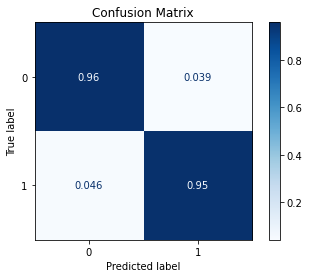

Acuracy: 96.03%

Precision:  0.7883596986976893

Recall:  0.957272421901243

F1 =  0.8497889596954399

ROC AUC =  0.9898958683238159


In [7]:
model = dp.train_model_plot_results(train_x, train_y, test_x, test_y, model_name="xgb", train_result=False, plot_pr=False)

------------
TEST
------------
[[1100   45]
 [   8   57]]


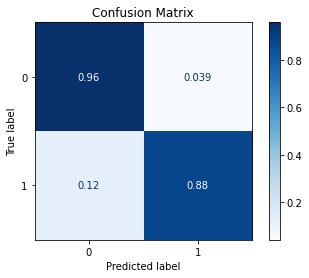

Acuracy: 95.62%

Precision:  0.7758016564026333

Recall:  0.9188108834397044

F1 =  0.829555270284996

ROC AUC =  0.9331877729257643


In [8]:
model = dp.train_model_plot_results(train_x, train_y, test_x, test_y, model_name="knn", train_result=False, plot_pr=False)

For a baseline, XGBoost and KNN have F1 scores around 0.86 (this will depend on your train/test split if you rerun this notebook). We will now proceed to try and improve on these results.

## 3 - Data Transformation

### DataMinMaxScaler

The first data transformation we will perform is a MinMaxScaler, which will scale each feature to have a range between zero and one. This does not improve the results.

------------
TEST
------------
[[1003  142]
 [  15   50]]


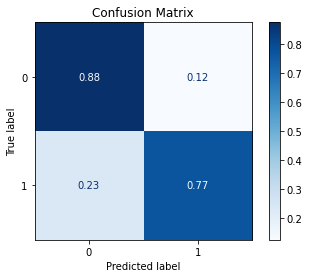

Acuracy: 87.02%

Precision:  0.6228409462999345

Recall:  0.8226066509909304

F1 =  0.6582603424052558

ROC AUC =  0.8433053409472623


In [9]:
scaler = dp.DataMinMaxScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = dp.train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model_name="knn", train_result=False, plot_pr=False)

### DataNormalizer

Next we try `DataNormalizer`, which will scale the vectors to have unit norm (i.e. vector of length one). This is often used in text classification, but we will use it here as well. But it does not improve the results.

No columns specified for imputation. These columns have been automatically identified:
[]
------------
TEST
------------
[[1100   45]
 [   5   60]]


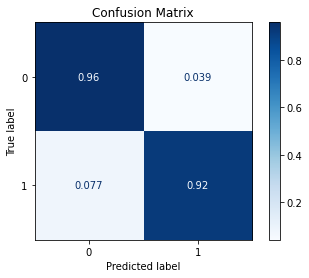

Acuracy: 95.87%

Precision:  0.7834518422753717

Recall:  0.9418878065166275

F1 =  0.8418300653594771

ROC AUC =  0.9543836076587169


In [10]:
scaler = dp.DataNormalizer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = dp.train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model_name="knn", train_result=False, plot_pr=False)

### DataStandardScaler

The standard scaler sets the mean to zero and scales the vectors to have unit variance.

------------
TEST
------------
[[1076   69]
 [  11   54]]


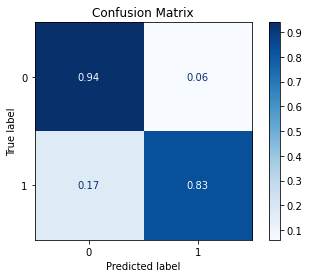

Acuracy: 93.39%

Precision:  0.7144523975138556

Recall:  0.8852536110178032

F1 =  0.7693128955997866

ROC AUC =  0.9034329862277461


In [11]:
scaler = dp.DataStandardScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = dp.train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model_name="knn", train_result=False, plot_pr=False)

### DataQuantileTransformer

The Quantile Transformer transforms the each feature to have a normal distribution.

------------
TEST
------------
[[1094   51]
 [   5   60]]


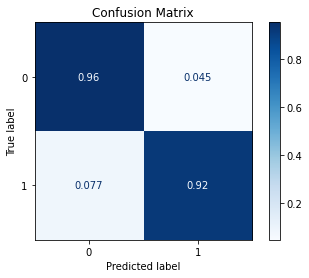

Acuracy: 95.37%

Precision:  0.7679954750018445

Recall:  0.939267719180383

F1 =  0.8284313725490196

ROC AUC =  0.955115888478334


In [12]:
scaler = dp.DataQuantileTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = dp.train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model_name="knn", train_result=False, plot_pr=False)

As we can see, this transformation had some impact in the results (depends on the seed used) when we use KNN. Let's check how this data transformation impacts the XGBoost model:

------------
TEST
------------
[[1100   45]
 [   3   62]]


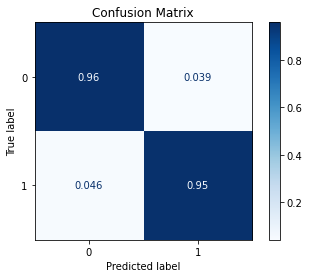

Acuracy: 96.03%

Precision:  0.7883596986976893

Recall:  0.957272421901243

F1 =  0.8497889596954399

ROC AUC =  0.9899361773597581


In [13]:
model = dp.train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model_name="xgb", train_result=False, plot_pr=False)

As depicted above, the results for the XGBoost remains the same as before. This shows us that data transformations are more impactful in certain models and less meaningful in others.

### DataRobustScaler

The robust scaler centers the data (median=zero) and scales the data based on the interquartile range (IQR).

------------
TEST
------------
[[1105   40]
 [   5   60]]


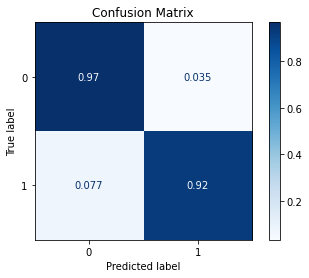

Acuracy: 96.28%

Precision:  0.7977477477477477

Recall:  0.9440712126301647

F1 =  0.853658536585366

ROC AUC =  0.9577426939872354


In [14]:
scaler = dp.DataRobustScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = dp.train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model_name="knn", train_result=False, plot_pr=False)

### DataPowerTransformer

The power transformer makes the data more Gaussian-like (by default using the Yeo-Johnson transform).

------------
TEST
------------
[[1105   40]
 [   5   60]]


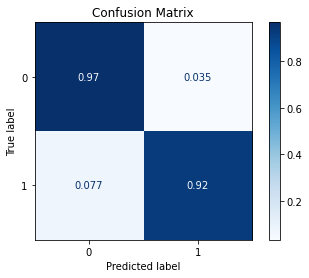

Acuracy: 96.28%

Precision:  0.7977477477477477

Recall:  0.9440712126301647

F1 =  0.853658536585366

ROC AUC =  0.9568558951965066


In [15]:
scaler = dp.DataPowerTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = dp.train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model_name="knn", train_result=False, plot_pr=False)

## 4 - Feature Selection

Without much success at improving the F1-score using the data scalers, we will proceed to feature selection to improve the model. We start out with 5 features, and use feature selection to remove unneeded features.

In [16]:
feat_sel = dp.SeqFeatSelection(n_jobs=4, forward=False)
feat_sel.fit(X=train_x_scl, y=train_y)
train_x_sel = feat_sel.transform(train_x_scl)
test_x_sel = feat_sel.transform(test_x_scl)

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.6s finished

[2022-08-02 12:30:10] Features: 4/1 -- score: 0.8853169756008183[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished

[2022-08-02 12:30:10] Features: 3/1 -- score: 0.836481331623253[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.4s finished

[2022-08-02 12:30:14] Features: 2/1 -- score: 0.8715549855287846[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.2s finished

[2022-08-02 12:30:18] Features: 1/1 -- score: 0.5507882838618479

In [17]:
feat_sel.get_selected_features()

['Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']

Here, sequential feature selection has removed one of the features (SD_pan), which has led to a slight improvement in F1-score.

------------
TEST
------------
[[1119   26]
 [   4   61]]


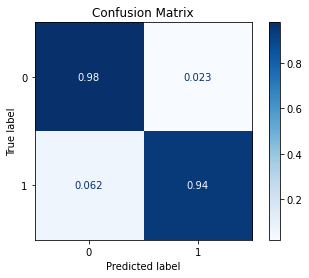

Acuracy: 97.52%

Precision:  0.8487937687434111

Recall:  0.9578770574403762

F1 =  0.8947020328599276

ROC AUC =  0.9660194827007055


In [18]:
model = dp.train_model_plot_results(train_x_sel, train_y, test_x_sel, test_y, model_name="knn", train_result=False, plot_pr=False)

## 5 - Synthetic Data

### imblearn Library

With unbalanced classes, we can instead choose to create synthetic data for the minority class. Here we use `Rebalance`, which connects to the `imblearn` library.

In [19]:
train_y.value_counts()

0    3433
1     196
Name: class, dtype: int64

In [20]:
rebalance = dp.Rebalance(
				X=train_x_sel,
				y=train_y,
				strategy_over={0:3433, 1:400},
				over_sampler=True,
				under_sampler=False
			)
train_x_res, train_y_res = rebalance.fit_resample()
train_y_res.value_counts()

No columns specified for imputation. These columns have been automatically identified:
[]
Running oversampling...
...finished


0    3433
1     400
Name: class, dtype: int64

------------
TEST
------------
[[1117   28]
 [   3   62]]


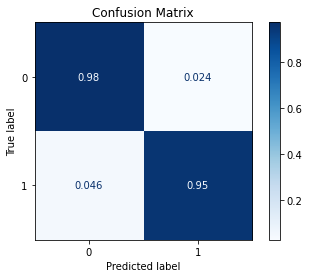

Acuracy: 97.44%

Precision:  0.8431051587301588

Recall:  0.9646960026872691

F1 =  0.8931567328918323

ROC AUC =  0.9732616728249917


In [21]:
model = dp.train_model_plot_results(train_x_res, train_y_res, test_x_sel, test_y, model_name="knn", train_result=False, plot_pr=False)

### Creating Artificial Data using Deep Learning

#### CTGAN

Let's use the dataset with the original categorical variables, since CTGAN is capable of dealing with categorical variables internally. We will start by re-encoding the ordinal variables. We then proceed to split the dataset before using the CTGAN. This guarantees that we don't contaminate our test set.

In [22]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=400,
				model="ctgan",
				load_existing=True
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

syn_train_y.value_counts()

Loading existing sythesizer model (CTGAN_400.pkl)...
LOADED model of class CTGAN.


0    3433
1     396
Name: class, dtype: int64

In [23]:
model = dp.train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model_name="knn", train_result=False, plot_pr=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Let's try creating more artificial instances and check how this impacts the model's performance.

In [ ]:
conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=2000, conditions=conditions)

model = dp.train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model_name="knn", train_result=False, plot_pr=False)

#### TVAE

In [ ]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=400,
				model="tvae",
				load_existing=True
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn2_train_x, syn2_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

model = dp.train_model_plot_results(syn2_train_x, syn2_train_y, test_x_sel, test_y, model_name="knn", train_result=False, plot_pr=False)